In [1]:
from framed.io_utils.sbml import load_cbmodel
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

/Users/daniel/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%run '../src/straindesign.py'

## Load iAF1260 (MCS customized) model 

In [4]:
model = load_cbmodel('../../models/iAF1260_MCSEnum.xml', flavor='cobra')
model_ext = load_cbmodel('../../models/iAF1260_MCSEnum_unfolded.xml', flavor='cobra')

biomass = model.detect_biomass_reaction()
product = 'R_EX_etoh_e'
oxygen = 'R_EX_o2_e'
glucose = 'R_EX_glc_e'
objective = lambda v: v[product]
min_growth = 0.001
max_uptake = 10
min_yield = 1.4
min_prod = min_yield*max_uptake
model.set_lower_bound(oxygen, 0)
model.set_lower_bound(glucose, -max_uptake)
constraints={biomass: (min_growth, 1e10), product: (min_prod, 1e10)}

Biomass reaction detected: R_Ec_biomass_iAF1260_core_59p81M


## Load gpr-based MCSEnumerator results (scenario 1)

In [16]:
data = loadmat('../../results/mcs/mcs_iAF1260_gpr_MCSEnum_max8.mat')
cmcs = pd.DataFrame(data['cmcs'].T, index=model_ext.reactions.keys())
gene_dels = [cmcs[cmcs[col] == 1].index.tolist() for col in cmcs]
gene_dels = [[r_id[len('u_'):] for r_id in gene_set] for gene_set in gene_dels]

## Analyse results

In [17]:
%time gene2rxns = gene_to_reaction_sets2(model, gene_dels)

CPU times: user 9.4 s, sys: 176 ms, total: 9.57 s
Wall time: 9.82 s


In [18]:
%time solution_pool = build_reaction_solution_pool2(model, gene2rxns, constraints)

CPU times: user 10.4 s, sys: 149 ms, total: 10.6 s
Wall time: 12.2 s


In [19]:
sizes = sorted(set(map(len, gene_dels)))

columns = ['gene-based cMCSs', 'reaction-wise total', 'valid', 'reaction deletion size']
stats = pd.DataFrame([], columns=columns)
total_set_count = []
rxn_set_count = []
rxn_set_sizes = []

for n_dels in sizes:
    total_sets = [tuple(sorted(gene_set)) for gene_set in gene_dels
                  if len(gene_set) == n_dels]
    total_set_count.append(len(total_sets))

    rxn_sets = set([gene2rxns[gene_set] for gene_set in total_sets])
    rxn_set_count.append(len(rxn_sets))

    valid_rxn_sets = [rxn_set for rxn_set in rxn_sets 
                      if solution_pool[rxn_set].valid]

    rxn_set_size = map(len, rxn_sets)
    rxn_set_sizes.append(rxn_set_size)

    stats.loc[n_dels] = (len(total_sets),
                      len(rxn_sets),
                      len(valid_rxn_sets),
                      '[{} - {}]'.format(min(rxn_set_size), max(rxn_set_size)))

stats.index.name = 'n dels'

In [20]:
stats

,gene-based cMCSs,reaction-wise total,valid,reaction deletion size
n dels,,,,
4,8,8,7,[3 - 7]
5,40,6,6,[5 - 22]
6,1978,10,10,[4 - 22]


In [12]:
colors = sns.color_palette()

/Users/daniel/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


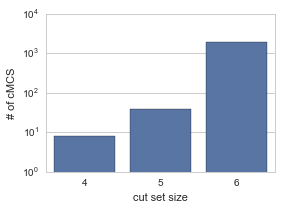

In [21]:
plt.figure(figsize=(4,3))
sns.barplot(sizes, total_set_count, log=True, color=colors[0])
plt.xlabel('cut set size')
plt.ylabel('# of cMCS')
plt.tight_layout()
plt.savefig('../results/mcs/plots/gpr_cmcs_size.png', dpi=150)

([<matplotlib.axis.YTick at 0x112e95fd0>,
 <a list of 4 Text yticklabel objects>)

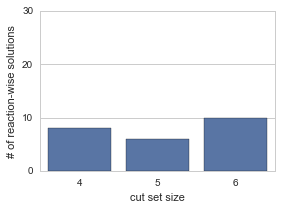

In [22]:
plt.figure(figsize=(4,3))
sns.barplot(sizes, rxn_set_count, color=colors[0])
plt.xlabel('cut set size')
plt.ylabel('# of reaction-wise solutions')
plt.tight_layout()
plt.yticks([0, 10, 20, 30])
plt.savefig('../results/mcs/plots/gpr_rxn_sols.png', dpi=150)

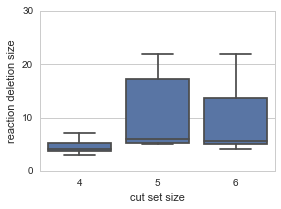

In [23]:
plt.figure(figsize=(4,3))
ax = sns.boxplot(pd.DataFrame(rxn_set_sizes, index=sizes).T, fliersize=5, sym='o', color=colors[0])
plt.xlabel('cut set size')
plt.ylabel('reaction deletion size')
plt.yticks([0, 10, 20, 30])
plt.tight_layout()
plt.savefig('../results/mcs/plots/gpr_rxn_cut_size.png', dpi=150)